# Exercise 1: Magnetostatics

In [2]:
include(joinpath(@__DIR__, "config.jl"))
paths = get_project_paths("examples")

# Ensure the module is reloaded if changed
if isdefined(Main, :MagnetostaticsFEM)
    println("Reloading MagnetostaticsFEM...")
    # A simple way to force reload in interactive sessions
    try; delete!(LOAD_PATH, joinpath(paths["SRC_DIR"], "src")); catch; end
    try; delete!(Base.loaded_modules, Base.PkgId(Base.UUID("f8a2b3c4-d5e6-f7a8-b9c0-d1e2f3a4b5c6"), "MagnetostaticsFEM")); catch; end
end
include(joinpath(paths["SRC_DIR"], "MagnetostaticsFEM.jl"))

using LinearAlgebra
using Plots
using LaTeXStrings
using Gridap
using .MagnetostaticsFEM

Reloading MagnetostaticsFEM...


┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.WeakFormProblem :: Union{}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetostatics_1d_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_1d_harmonic_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_1d_harmonic_coupled_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_2d_harmon

## Define Parameters and Paths

In [3]:
# Model Parameters
J = 2.2e4       # Current density [A/m²]
μ0 = 4e-7 * pi  # Vacuum permeability [H/m]
μr = 1500.       # Relative permeability of the core

# FEM Parameters
order = 2
dirichlet_tag = "D"
dirichlet_value = 0.0

mesh_file = joinpath(paths["GEO_DIR"], "coil_geo.msh")

println("Mesh file: ", mesh_file)
println("Output directory: ", paths["OUTPUT_DIR"])

Mesh file: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh
Output directory: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output


## Setup FEM Problem

In [4]:
# Load mesh and tags
model, labels, tags = load_mesh_and_tags(mesh_file)

# Get material tags dictionary
material_tags = get_material_tags(labels)

# Define Lagrangian reference element (No longer needed here)
# reffe = ReferenceFE(lagrangian, Float64, order)

# Set up triangulation and measures
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)

# Define material property functions
reluctivity_func = define_reluctivity(material_tags, μ0, μr)
current_density_func = define_current_density(material_tags, J)

# Setup FE spaces using the updated signature
U, V = setup_fe_spaces(model, order, Float64, dirichlet_tag, dirichlet_value)

# Define the weak form problem
problem = magnetostatics_1d_weak_form(Ω, dΩ, tags, reluctivity_func, current_density_func)

Info    : Reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh'
Setting up single-field space.


WeakFormProblem(Main.MagnetostaticsFEM.var"#a#24"{Gridap.CellData.GenericMeasure, Main.MagnetostaticsFEM.var"#reluctivity#3"{Main.MagnetostaticsFEM.var"#permeability#2"{String, Dict{String, Int64}, Float64, Float64}}, Gridap.CellData.GenericCellField{ReferenceDomain}}(GenericMeasure(), Main.MagnetostaticsFEM.var"#reluctivity#3"{Main.MagnetostaticsFEM.var"#permeability#2"{String, Dict{String, Int64}, Float64, Float64}}(Main.MagnetostaticsFEM.var"#permeability#2"{String, Dict{String, Int64}, Float64, Float64}("Core", Dict("Core" => 3, "Coil2" => 5, "Air" => 2, "Coil1" => 4), 1.2566370614359173e-6, 1500.0)), GenericCellField()), Main.MagnetostaticsFEM.var"#b#25"{Gridap.CellData.GenericMeasure, Main.MagnetostaticsFEM.var"#current_density#9"{Vector{String}, Vector{String}, Dict{String, Int64}, Float64}, Gridap.CellData.GenericCellField{ReferenceDomain}}(GenericMeasure(), Main.MagnetostaticsFEM.var"#current_density#9"{Vector{String}, Vector{String}, Dict{String, Int64}, Float64}(["Coil1"], [

## Solve FEM Problem

In [5]:
# Solve the linear FE system
Az = solve_fem_problem(problem, U, V)

SingleFieldFEFunction():
 num_cells: 113
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 638226790370725814

## Post-processing

In [6]:
# Compute B-field from Az
B = calculate_b_field(Az)

# Save results to VTK format
save_results_vtk(Ω, joinpath(paths["OUTPUT_DIR"], "static_1d"), Dict("Az" => Az, "B" => B))

Results saved to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output/static_1d.vtu


## Visualization

In [7]:
# Define geometry boundaries for plotting (from geometry_definition.ipynb)
a_len = 100.3e-3
b_len = 73.15e-3
c_len = 27.5e-3
xa1 = -a_len/2
xb1 = -b_len/2
xc1 = -c_len/2
xc2 = c_len/2
xb2 = b_len/2
xa2 = a_len/2

0.05015

In [8]:
# Define points for visualization
x_int = collect(range(-0.1, 0.1, length=1000))

# Evaluate solutions at interpolation points
coord = [VectorValue(x_) for x_ in x_int]
Az_values = Az(coord)
B_values = B(coord)
By_values = [b[1] for b in B_values]  # Extract y-component (B = -dAz/dx)

# Define region boundaries for plotting
boundaries = [xa1, xb1, xc1, xc2, xb2, xa2]

# Calculate midpoints for region labels
x_min_plot = minimum(x_int)
x_max_plot = maximum(x_int)
midpoints = [
    (x_min_plot + xa1)/2, (xa1 + xb1)/2, (xb1 + xc1)/2, (xc1 + xc2)/2,
    (xc2 + xb2)/2, (xb2 + xa2)/2, (xa2 + x_max_plot)/2
]
region_labels = ["Air", "Core", "Coil L", "Core", "Coil R", "Core", "Air"]

7-element Vector{String}:
 "Air"
 "Core"
 "Coil L"
 "Core"
 "Coil R"
 "Core"
 "Air"

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


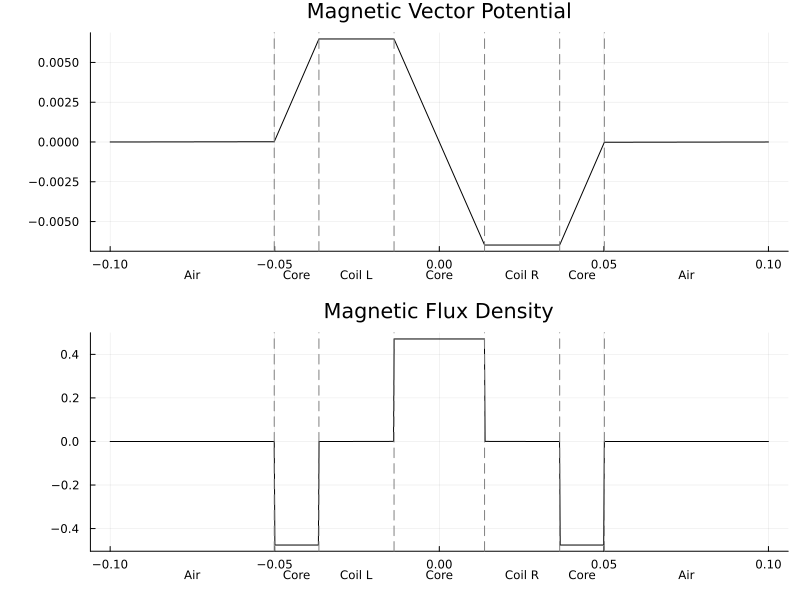

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [9]:
using .MagnetostaticsFEM.Visualisation
magnetostatics_1d_plot(
  x_int, Az_values, By_values;
  boundaries=boundaries,
  region_labels=region_labels,
  output_path=joinpath(paths["OUTPUT_DIR"], "magnetostatics_1d.pdf")
)